In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, InputLayer, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from tensorflow.keras.utils import model_to_dot, plot_model
from IPython.display import SVG

In [4]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)
'TensorFlow version: ' + tf.__version__

'TensorFlow version: 2.5.0'

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.
x_train.shape

(60000, 28, 28, 1)

In [7]:
img_rows, img_cols, img_chns = x_train.shape[1:]
original_dim = img_rows * img_cols
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

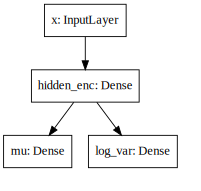

In [9]:
# inference network
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)
m = Model(inputs=x, outputs=[z_mu, z_log_var])
display(SVG(model_to_dot(m, show_shapes=False, dpi=65)
        .create(prog='dot', format='svg')))

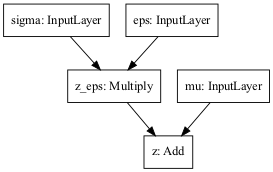

In [12]:
plot_model(
    model=m, show_shapes=False,
    dpi=65,
    to_file='LT_inference_network.png'
)

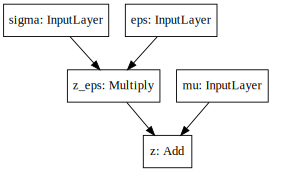

In [13]:
# reparamerization with merge layers
z_mu = Input(shape=(latent_dim,), name='mu')
z_sigma = Input(shape=(latent_dim,), name='sigma')
eps = Input(shape=(latent_dim,), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])
m = Model(inputs=[eps, z_mu, z_sigma], outputs=z)
SVG(model_to_dot(m, show_shapes=False, dpi=65)
    .create(prog='dot', format='svg'))

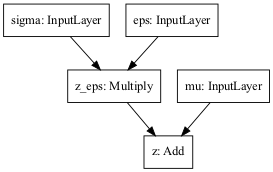

In [14]:
plot_model(
    model=m, show_shapes=False,
    dpi=65,
    to_file='reparameterization.png'
)

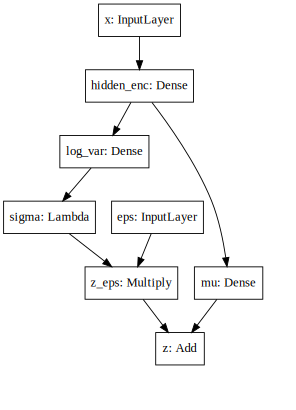

In [15]:
# simplified architecture visualization:
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)
eps = Input(shape=(latent_dim,), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])
encoder = Model(inputs=[x, eps], outputs=z)
SVG(model_to_dot(encoder, show_shapes=False, dpi=65)
    .create(prog='dot', format='svg'))

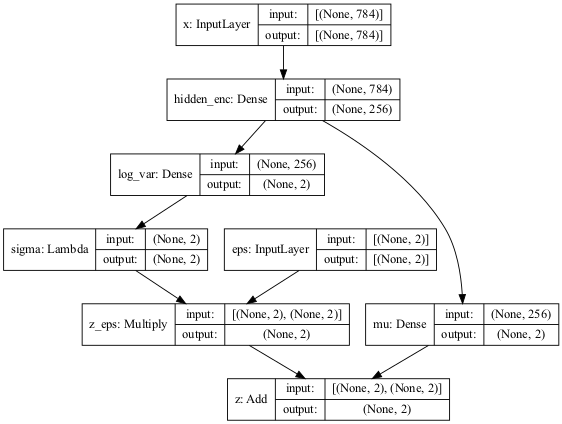

In [16]:
plot_model(
    model=encoder, show_shapes=False, dpi=65,
    to_file='encoder.png'
)

plot_model(
    model=encoder, show_shapes=True, dpi=65,
    to_file='encoder_shapes.png'
)

In [17]:
# full archetecture visualization with auxilatary layers
class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

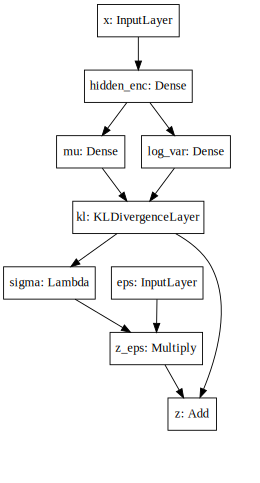

In [19]:
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_mu, z_log_var = KLDivergenceLayer(name='kl')([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)
eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          latent_dim)), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])
encoder = Model(inputs=[x, eps], outputs=z)
SVG(model_to_dot(encoder, show_shapes=False, dpi=65,)
    .create(prog='dot', format='svg'))

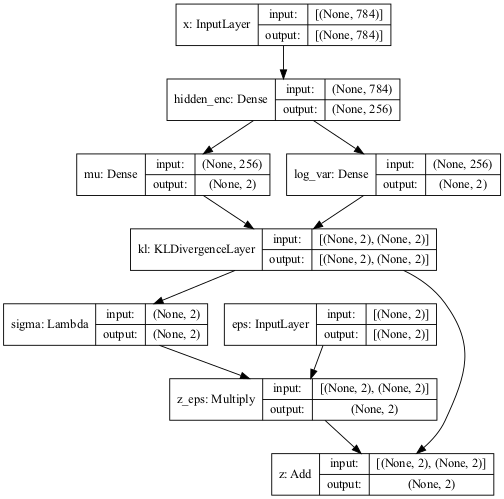

In [20]:
plot_model(
    model=encoder, show_shapes=False, dpi=65,
    to_file='encoder_full.png'
)

plot_model(
    model=encoder, show_shapes=True, dpi=65,
    to_file='encoder_full_shapes.png'
)

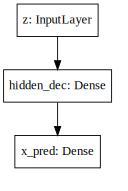

In [21]:
decoder = Sequential([
  Dense(intermediate_dim, input_dim=latent_dim, 
        activation='relu', name='hidden_dec'),
  Dense(original_dim, activation='sigmoid', name='x_pred')
], name='decoder')

# equivalent to above. we specify InputLayer 
# explicitly to set layer name for architecture diagram 
decoder = Sequential([
    InputLayer(input_shape=(latent_dim,), name='z'),
    Dense(intermediate_dim, input_shape=(latent_dim,),
          activation='relu', name='hidden_dec'),
    Dense(original_dim, activation='sigmoid', name='x_pred')], name='decoder')
SVG(model_to_dot(decoder, show_shapes=False, dpi=65).create(prog='dot', format='svg'))

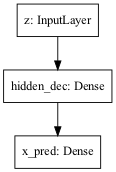

In [22]:
plot_model(
    model=decoder, show_shapes=False, dpi=65,
    to_file='decoder.png'
)

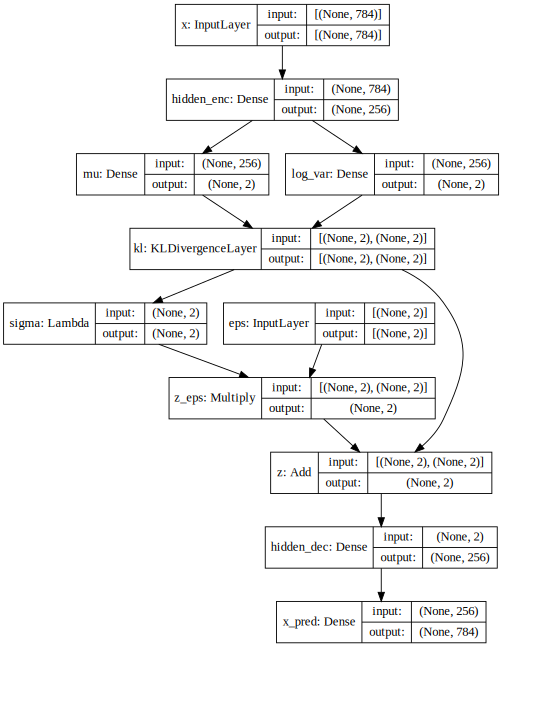

In [23]:
x_pred = decoder(z)
# again, equivalent to above. fleshing it out fully
# for final end-to-end vae architecture visualization;
# otherwise, sequential models just get chunked into
# single layer
h_dec = Dense(intermediate_dim, activation='relu', 
              name='hidden_dec')(z)
x_pred = Dense(original_dim, activation='sigmoid', 
               name='x_pred')(h_dec)

vae = Model(inputs=[x, eps], outputs=x_pred)

SVG(model_to_dot(vae, show_shapes=True, dpi=65)
    .create(prog='dot', format='svg'))

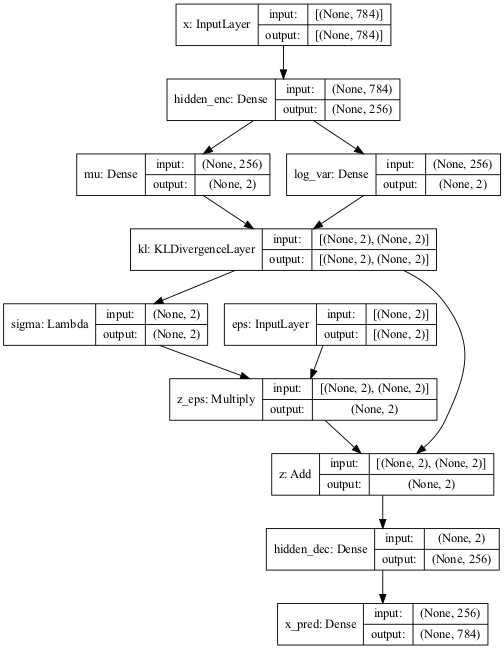

In [24]:
plot_model(
    model=vae, show_shapes=False, dpi=65,
    to_file='vae_full.png'
)

plot_model(
    model=vae, show_shapes=True, dpi=65,
    to_file='vae_full_shapes.png'
)

In [25]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = decoder(z)
vae = Model(inputs=[x, eps], outputs=x_pred, name='vae')
vae.compile(optimizer='rmsprop', loss=nll)

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-29 09:50:52.615347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 09:50:52.615600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-29 09:50:52.637575: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-29 09:50:52.638712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-29 09:50:52.675342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-29 09:50:52.843770: I tensorflow/core/grappler/o

59900/60000 [============================>.] - ETA: 0s - loss: 190.6067

/Users/tomxu/miniforge3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-05-29 09:51:00.876625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


60000/60000 [==============================] - 9s 144us/sample - loss: 190.5602 - val_loss: 172.3409
Epoch 2/50
60000/60000 [==============================] - 7s 117us/sample - loss: 170.9704 - val_loss: 168.4235
Epoch 3/50
60000/60000 [==============================] - 7s 117us/sample - loss: 167.3023 - val_loss: 165.6971
Epoch 4/50
60000/60000 [==============================] - 7s 115us/sample - loss: 164.7931 - val_loss: 163.5369
Epoch 5/50
60000/60000 [==============================] - 7s 117us/sample - loss: 162.8524 - val_loss: 161.9625
Epoch 6/50
60000/60000 [==============================] - 7s 113us/sample - loss: 161.2698 - val_loss: 160.8793
Epoch 7/50
60000/60000 [==============================] - 7s 117us/sample - loss: 160.0369 - val_loss: 159.5437
Epoch 8/50
60000/60000 [==============================] - 7s 120us/sample - loss: 159.0550 - val_loss: 158.5981
Epoch 9/50
60000/60000 [==============================] - 7s 115us/sample - loss: 158.2387 - val_loss: 158.3971
Epo

In [27]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

In [28]:
# NELBO
fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())

plt.savefig('nelbo.png')
plt.show()

<IPython.core.display.Javascript object>

In [29]:
# observed space manifold
# display a 2D manifold of the images
n = 15  # figure with 15x15 images
quantile_min = 0.01
quantile_max = 0.99

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, img_rows, img_cols)

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')

ax.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)
ax.set_xticklabels(map('{:.2f}'.format, z1), rotation=90)

ax.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)
ax.set_yticklabels(map('{:.2f}'.format, z2))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.savefig('result_manifold.png')
plt.show()

/Users/tomxu/miniforge3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-05-29 11:34:38.922215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


<IPython.core.display.Javascript object>

In [ ]:
# deterministic test time encoder
test_encoder = Model(x, z_mu)
# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6, 5))
cbar = ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax)
ax.set_xlim(2.*norm.ppf((quantile_min, quantile_max)))
ax.set_ylim(2.*norm.ppf((quantile_min, quantile_max)))
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.savefig('result_latent_space.png')
plt.show()

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4.5))

ax1.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')

ax1.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)
ax1.set_xticklabels(map('{:.2f}'.format, z1), rotation=90)

ax1.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)
ax1.set_yticklabels(map('{:.2f}'.format, z2))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

cbar = ax2.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax2)

ax2.set_xlim(2.*norm.ppf((quantile_min, quantile_max)))
ax2.set_ylim(2.*norm.ppf((quantile_min, quantile_max)))

ax2.set_xlabel('$z_1$')
ax2.set_ylabel('$z_2$')

plt.savefig('result_combined.png')
plt.show(block=False)

<IPython.core.display.Javascript object>